In [71]:
import gpytorch.kernels as kernel
import torch
import numpy as np
from src.test_statistics import *
from src.data import *
import random
import numpy as np
from src.test import *
import pandas as pd

In [2]:
X_ker = kernel.RBFKernel(ard_num_dims=3)
Y_ker = kernel.RBFKernel(ard_num_dims=1)

In [3]:
kernel_X =ker(X_ker)

In [4]:
X_ker.lengthscale = 10

In [5]:
n=200
d=3
X = torch.randn((n,d))
Y = torch.randn(n)
T = (torch.randn((n))>0).float()

In [6]:
from src.utils import compute_median_heuristic
from sklearn.metrics import pairwise_distances

In [7]:
X_ker.lengthscale = compute_median_heuristic(X)
Y_ker.lengthscale = compute_median_heuristic(Y)

In [8]:
Y_ker.lengthscale

tensor([[0.9719]], grad_fn=<SoftplusBackward0>)

In [9]:
np.median(pairwise_distances(Y.reshape(-1,1)))

0.9718648

In [10]:
compute_median_heuristic(X)
Y = Y.unsqueeze(0)
median_heuristic = [np.median(pairwise_distances(Y[:, [i]].reshape(-1,1))) for i in range(Y.shape[1])]
median_heuristic = median_heuristic[0]
Y =Y.squeeze(0)

In [11]:
X.shape[0]

200

In [12]:
a =torch.tensor([1,1],dtype=float) 

In [13]:
data_train = Data_object(X,Y,T)
data_train_flip = Data_object(X,Y,1-T)

In [14]:
m=200
X = torch.randn((m,d))
Y = torch.randn(m)
T = (torch.randn((m))>0).float()

In [15]:
Y1 = torch.randn((1))

In [16]:
data_test = Data_object(X,Y,T)
data_test_flip = Data_object(X,Y,1-T)

In [17]:
W0 = get_W_matrix(X_ker(data_train.X0).evaluate(),1,func="cme")
W1 = get_W_matrix(X_ker(data_train.X1).evaluate(),1,func="cme")

In [18]:
W0

tensor([[ 1.5970e+00, -1.2989e-02, -4.5052e-02,  ..., -3.3693e-02,
          2.0625e-02,  4.0120e-02],
        [-1.2989e-02,  1.6724e+00, -2.8556e-02,  ..., -7.9427e-04,
         -1.0089e-02, -1.3342e-02],
        [-4.5052e-02, -2.8556e-02,  1.8073e+00,  ..., -4.5172e-02,
         -1.2455e-02, -1.9361e-02],
        ...,
        [-3.3693e-02, -7.9427e-04, -4.5172e-02,  ...,  1.1206e+00,
         -3.7153e-01,  1.4366e-02],
        [ 2.0625e-02, -1.0089e-02, -1.2455e-02,  ..., -3.7153e-01,
          9.8667e-01, -7.7879e-02],
        [ 4.0120e-02, -1.3342e-02, -1.9361e-02,  ...,  1.4366e-02,
         -7.7879e-02,  9.8049e-01]], grad_fn=<CholeskyInverseBackward0>)

In [19]:
weights = 1/2*torch.ones(m)

In [20]:
K = ker(X_ker)
L = ker(Y_ker)

In [21]:
a = X_ker(X,X)

In [22]:
Y_ker.lengthscale

tensor([[0.9719]], grad_fn=<SoftplusBackward0>)

In [23]:
c = (data_test.T - weights)/(weights*(1-weights))
c

tensor([ 2., -2.,  2., -2.,  2.,  2., -2.,  2.,  2.,  2., -2., -2.,  2., -2.,
         2.,  2., -2.,  2.,  2., -2.,  2., -2., -2.,  2.,  2., -2.,  2., -2.,
         2.,  2., -2.,  2., -2.,  2., -2.,  2., -2.,  2.,  2.,  2., -2., -2.,
        -2., -2.,  2.,  2., -2.,  2., -2., -2., -2., -2., -2.,  2.,  2.,  2.,
         2., -2., -2., -2., -2., -2., -2., -2.,  2.,  2., -2.,  2., -2.,  2.,
        -2., -2.,  2.,  2., -2., -2.,  2.,  2.,  2.,  2., -2., -2., -2.,  2.,
        -2., -2., -2., -2.,  2., -2.,  2., -2., -2., -2., -2.,  2.,  2.,  2.,
         2., -2., -2.,  2.,  2.,  2.,  2., -2.,  2.,  2., -2., -2.,  2., -2.,
         2., -2., -2., -2., -2., -2.,  2.,  2.,  2.,  2., -2., -2., -2., -2.,
         2.,  2.,  2., -2., -2.,  2., -2., -2.,  2.,  2.,  2.,  2.,  2., -2.,
        -2.,  2.,  2.,  2., -2.,  2.,  2.,  2., -2.,  2., -2., -2., -2., -2.,
        -2.,  2.,  2., -2.,  2., -2., -2.,  2., -2., -2., -2.,  2.,  2.,  2.,
         2., -2., -2.,  2.,  2.,  2.,  2.,  2.,  2., -2., -2., -

In [24]:
data_train.Y.shape

torch.Size([200])

In [25]:
L(data_train.Y0,data_train.Y).shape

torch.Size([101, 200])

In [26]:
DATE_test_stat(data_train,data_test,X_ker,Y_ker,weights,W0,W1)

0.013968516141176224

In [27]:
DETT_test_stat(data_train,data_test,X_ker,Y_ker,weights,W1)

0.0035415056627243757

In [28]:
L(data_train.Y0,data_test.Y)@ c

tensor([ -3.7448, -11.1710,  -7.5483,  10.0541,  10.8119, -13.3192,  -8.8508,
        -16.0858,  15.1418,   6.4991,  -7.8953,   5.2132, -16.4408,  -3.7641,
         11.7122,  -4.1217, -16.3331, -16.0516,  13.6845,  14.9457, -13.2288,
        -16.1492,  -0.1522,  10.8618,   9.2428,   7.8097,  14.5556,   7.3841,
        -10.4389,  12.1569,  -0.6448,   5.2814,   2.8279,  15.4367,  11.4813,
          6.7974,   3.3252,  -4.8552, -11.2262,  12.4203,  14.7818, -10.5362,
         14.3140,   8.8270,   2.6538,  -6.0073, -14.7475,  -5.0779,  -2.5122,
          2.6543,  15.1849,  10.5653,  -4.9355,  -9.3487, -11.7924,   1.6635,
         14.2538,  -2.0911,   8.9107, -12.6163, -13.7546,  -5.8813,   9.9019,
          4.7069,  13.4515,  -7.0814, -14.8007, -15.2987,   0.1341,   2.6904,
        -15.9109, -16.0275,  15.3182, -16.4318,  -0.8110,  14.5260, -16.4420,
         10.5987,   9.3020,   6.1776,  -1.3762,  14.5772,  -7.0189,  -5.7657,
         -6.4578,  15.4589, -16.3802,  -5.2758,  -8.4946,  -9.62

In [29]:
from sklearn.linear_model import LogisticRegression

In [30]:
weights_model = LogisticRegression()

In [31]:
weights_model.fit(data_train.X,data_train.T)
weights_train = weights_model.predict_proba(data_train.X)[:,1]
weights_test = weights_model.predict_proba(data_test.X)[:,1]

In [32]:
def DATE_goodness_of_fit(fit_samples,data_train,data_test,X_ker,Y_ker,weights,Wt,t=1):
        
        n = len(fit_samples)
        m = len(data_test.Y)

        K = ker(X_ker)
        L = ker(Y_ker)

        t_vec = (data_test.T == t).long()
        w = (t_vec)*1/(weights)

        fit_stat = 1/(n**2)*L(fit_samples,fit_samples).sum()
        fit_stat += -2/(n*m)*(w @ L(data_test.Y,fit_samples)).sum()
        fit_stat += -2/(n*m)*((L(fit_samples,data_train.Y1) @ (Wt @ (K(data_train.X1,data_test.X) @ (1-w))))).sum()
        fit_stat += 1/(m**2) * (w @ (L(data_test.Y,data_test.Y)@ w))
        fit_stat += 1/(m**2)*2 * (w @ (L(data_test.Y,data_train.Y1) @ (Wt @ (K(data_train.X1,data_test.X)@ (1-w)))))
        fit_stat += 1/(m**2)*(1-w @ (K(data_test.X,data_train.X1) @ (Wt @ ( L(data_train.Y1,data_train.Y1) @ (Wt @ (K(data_train.X1,data_test.X)@ (1-w)) ) ))))
        return fit_stat.item()


In [33]:
from src.data import f_0,f_1
n_sample = 500

mu = [0,0,0,0,0,0,0,0,0,0]
sigma = ["C_ID",1.5]
noise = 0.2
g_0 = f_0
g_1 = f_1

In [34]:
data_train = shift_data_simulation(mu,sigma,g_0,g_1,noise,1000)
data_test = shift_data_simulation(mu,sigma,g_0,g_1,noise,1000)
weights_model.fit(data_train.X,data_train.T)
weights_train = weights_model.predict_proba(data_train.X)[:,1]
weights_test = weights_model.predict_proba(data_test.X)[:,1]

In [35]:
from src.utils import KMM_weights_for_W_matrix,kernel_mean_matching

In [36]:
X_ker = kernel.RBFKernel(ard_num_dims=10)

In [37]:
X_ker.lengthscale = 1

In [38]:
X_ker.lengthscale

tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]], grad_fn=<SoftplusBackward0>)

In [39]:
data_train.X1[0]

tensor([ 2.3427, -0.2785,  2.1795, -0.3675, -2.3813, -0.5511, -0.1140, -0.9373,
         1.6519,  1.7597])

In [40]:
a = KMM_weights_for_W_matrix(X_ker,data_train.X1,data_test.X,True)

     pcost       dcost       gap    pres   dres
 0:  1.9073e+02 -1.0960e+08  1e+08  8e-17  1e-12
 1:  1.9027e+02 -1.1071e+06  1e+06  1e-16  9e-13
 2:  1.5267e+02 -2.2762e+04  2e+04  2e-16  2e-14
 3:  6.7339e+00 -3.8026e+02  4e+02  1e-16  2e-15
 4: -3.9734e+01 -6.3599e+01  2e+01  1e-16  1e-15
 5: -4.5688e+01 -4.8278e+01  3e+00  1e-16  1e-15
 6: -4.6391e+01 -4.6675e+01  3e-01  1e-16  8e-16
 7: -4.6463e+01 -4.6493e+01  3e-02  1e-16  1e-15
 8: -4.6471e+01 -4.6474e+01  3e-03  2e-16  1e-15
 9: -4.6471e+01 -4.6472e+01  3e-04  3e-16  1e-15
10: -4.6471e+01 -4.6471e+01  2e-05  1e-16  9e-16
Optimal solution found.


In [41]:
from src.utils import get_W_matrix

In [42]:
Wt = get_W_matrix(X_ker(data_train.X1).evaluate(),c=1,func="zero",weights=a)

In [43]:
Wt.sum()

tensor(0.)

In [44]:
from src.test_statistics import DATE_goodness_of_fit

In [45]:
Wt = Wt.type(torch.float)
Wt.dtype

torch.float32

In [46]:
DETT_goodness_of_fit(data_train.Y,data_train,data_test,X_ker,Y_ker,weights=torch.ones(data_train.X.shape[0]),t=1,Wt=Wt)

0.3814334273338318

In [47]:
from src.test import goodness_of_fit_test

In [48]:
goodness_of_fit_test(data_train.Y,data_train,data_test,X_ker,Y_ker,weights_model,t=0,test_stat="DATE",reg=[1,1],func="zero", KMM_weights = False)

0.008147329092025757

In [49]:
goodness_of_fit_test(data_train.Y,data_train,data_test,X_ker,Y_ker,weights_model,t=0,test_stat="DATE",reg=[1,1],func="zero", KMM_weights = True)

     pcost       dcost       gap    pres   dres
 0: -8.6013e+01 -1.0959e+08  1e+08  9e-17  3e-13
 1: -8.6762e+01 -1.1102e+06  1e+06  1e-16  2e-13
 2: -1.3713e+02 -2.1280e+04  2e+04  2e-16  5e-15
 3: -2.3313e+02 -1.3286e+03  1e+03  2e-16  7e-16
 4: -2.4004e+02 -3.0591e+02  7e+01  2e-16  7e-16
 5: -2.4121e+02 -2.4370e+02  2e+00  2e-16  7e-16
 6: -2.4121e+02 -2.4124e+02  3e-02  1e-16  8e-16
 7: -2.4121e+02 -2.4121e+02  3e-04  1e-16  8e-16
 8: -2.4121e+02 -2.4121e+02  3e-06  1e-16  7e-16
Optimal solution found.


0.008147329092025757

In [50]:
KMM_weights = True
reg =[1,1]
func ="zero"
fit_samples = data_train.Y1
weights = torch.tensor(weights_model.predict_proba(data_test.X)[:,1]).float()

In [51]:
W0_weights_T = 1/KMM_weights_for_W_matrix(X_ker,data_train.X0,data_train.X,KMM_weights)            
W0_T = get_W_matrix(X_ker(data_train.X0).evaluate(),reg[0],func,weights=W0_weights_T)
DATE_goodness_of_fit(fit_samples,data_train,data_test,X_ker,Y_ker,1-weights,W0_T,t=1)

     pcost       dcost       gap    pres   dres
 0: -8.6013e+01 -1.0959e+08  1e+08  9e-17  3e-13
 1: -8.6762e+01 -1.1102e+06  1e+06  1e-16  2e-13
 2: -1.3713e+02 -2.1280e+04  2e+04  2e-16  5e-15
 3: -2.3313e+02 -1.3286e+03  1e+03  2e-16  7e-16
 4: -2.4004e+02 -3.0591e+02  7e+01  2e-16  7e-16


 5: -2.4121e+02 -2.4370e+02  2e+00  2e-16  7e-16
 6: -2.4121e+02 -2.4124e+02  3e-02  1e-16  8e-16
 7: -2.4121e+02 -2.4121e+02  3e-04  1e-16  8e-16
 8: -2.4121e+02 -2.4121e+02  3e-06  1e-16  7e-16
Optimal solution found.


0.001979619264602661

In [52]:
KMM_weights = False

In [53]:
fit_samples = data_train.Y0

In [54]:
W0_weights = 1/KMM_weights_for_W_matrix(X_ker,data_train.X0,data_train.X,KMM_weights)     
W0 = get_W_matrix(X_ker(data_train.X0).evaluate(),reg[0],func,weights=W0_weights)

In [55]:
kernel_X = ker(X_ker)
DATE_goodness_of_fit(fit_samples,data_train,data_test,X_ker,Y_ker,1-weights,W0,t=1)

0.01481732726097107

In [56]:
a,b,c = data_train.T,data_train.Y1,data_train.Y0

In [57]:
data_train.flip_T()

In [58]:
d,e,f = data_train.T,data_train.Y1,data_train.Y0

In [59]:
data_train.flip_T()

In [60]:
b = data_train.X1

In [61]:
b

tensor([[ 2.3427, -0.2785,  2.1795,  ..., -0.9373,  1.6519,  1.7597],
        [ 0.9745, -0.1785, -1.0947,  ..., -0.1749,  2.2632, -0.3206],
        [ 0.7694,  2.5361,  1.6850,  ..., -1.4470,  0.3946, -0.6785],
        ...,
        [-2.1216,  3.2268,  2.3483,  ..., -0.7136,  1.0923, -0.9426],
        [ 2.4299,  0.0501, -2.7514,  ...,  0.5549,  0.4863,  0.7422],
        [ 0.4407, -0.8472, -3.4213,  ...,  0.2158, -3.1063, -0.2842]])

In [69]:
# kernel_X = ker(X_ker)
DATE_goodness_of_fit(data_train.Y,data_train,data_test,X_ker,Y_ker,1-weights,W0,t=0)

0.008147329092025757

In [63]:
1-weights

tensor([0.5076, 0.4922, 0.5091, 0.4269, 0.5481, 0.5439, 0.4948, 0.5319, 0.4818,
        0.4417, 0.4827, 0.5064, 0.5008, 0.4735, 0.4671, 0.4575, 0.4447, 0.4907,
        0.5256, 0.4791, 0.5455, 0.4608, 0.4651, 0.4456, 0.5249, 0.5404, 0.4657,
        0.5359, 0.5353, 0.5420, 0.4485, 0.4745, 0.5535, 0.4965, 0.5519, 0.4820,
        0.5227, 0.4606, 0.5192, 0.4444, 0.4672, 0.4877, 0.5751, 0.4848, 0.4574,
        0.5468, 0.5080, 0.4894, 0.4659, 0.5728, 0.5458, 0.4721, 0.4610, 0.4695,
        0.4828, 0.4827, 0.5129, 0.5428, 0.5346, 0.4776, 0.5073, 0.5139, 0.4859,
        0.4923, 0.4891, 0.4430, 0.6029, 0.5096, 0.4873, 0.5223, 0.6000, 0.4525,
        0.5207, 0.4961, 0.4775, 0.5764, 0.4390, 0.5161, 0.5152, 0.5028, 0.5303,
        0.5520, 0.5657, 0.4795, 0.5965, 0.5240, 0.5384, 0.4977, 0.5488, 0.4073,
        0.4302, 0.5396, 0.4963, 0.4696, 0.4558, 0.4695, 0.5003, 0.5566, 0.5139,
        0.5300, 0.4680, 0.5273, 0.5103, 0.6018, 0.4771, 0.5666, 0.5634, 0.5280,
        0.5183, 0.4510, 0.5284, 0.5074, 

In [64]:
import numpy as np

In [65]:
c =kernel_mean_matching_3(X_ker,(data_train.X1), (data_test.X),B=100,eps=10000)


KeyboardInterrupt



In [ ]:
c.min(),c.max(),c.mean(),len(c)

(6.369902730505058e-09, 2.931789578722153, 0.15628347147136007, 500)

In [ ]:
n0 = 3

In [ ]:
G = torch.concat([torch.ones(1,n0),-torch.ones(1,n0),torch.eye(n0),-torch.eye(n0)])
G

tensor([[ 1.,  1.,  1.],
        [-1., -1., -1.],
        [ 1.,  0.,  0.],
        [ 0.,  1.,  0.],
        [ 0.,  0.,  1.],
        [-1., -0., -0.],
        [-0., -1., -0.],
        [-0., -0., -1.]])

In [ ]:
eps,B = 0.5,2
h = torch.concat([torch.tensor([n0 * (1 + eps),n0 * (eps - 1)]), B * torch.ones((n0,)),torch.zeros(n0) ])
h

tensor([ 4.5000, -1.5000,  2.0000,  2.0000,  2.0000,  0.0000,  0.0000,  0.0000])

In [ ]:
import yaml
import src.data as data

In [ ]:
f = getattr(data,"shift_data_simulation")

In [ ]:
with open("/Users/jakefawkes/Python/DR_distributional_test/config/run_simulated_shift_experiment.yaml", "r") as f:
    cfg = yaml.safe_load(f)

In [ ]:
cfg

{'experiment': {'n_iter': 30,
  'test_stat': ['DATE', 'DETT'],
  'ker_regress': ['cme', 'zero'],
  'weights_model': 'Linear',
  'X_ker': 'RBF',
  'Y_ker': 'RBF',
  'significance_level': 0.05,
  'n_bins': 20,
  'cme_reg': 0.01,
  'permute_weights': True,
  'KMM_weights': True},
 'data': {'generator': 'Logistic_Regression',
  'n_train_sample': 500,
  'n_test_sample': 500,
  'arguments': {'alpha_vec': [0.1, 0.2, 0.3, 0.4, 0.5],
   'beta_vec': [0.1, 0.2, 0.3, 0.4, 0.5],
   'beta_scalar': 0,
   'effect_var': 'Unif',
   'noise_Y': 0.2}}}

In [ ]:
def make_data(cfg):
    if cfg["data"]["generator"] == "shift_data_simulation":
        function_dict = {}
        for key in cfg["data"]["functions"]:
            function_dict[key] = getattr(data,cfg["data"]["functions"][key])
    data_train = shift_data_simulation(n_sample=cfg["data"]["n_train_sample"],**function_dict,**cfg["data"]["arguments"])
    data_test = shift_data_simulation(n_sample=cfg["data"]["n_test_sample"],**function_dict,**cfg["data"]["arguments"])
    return data_train,data_test

In [ ]:
a = shift_data_simulation(mu,sigma,g_0,g_1,noise,n_sample)

In [ ]:
float(True)

1.0

In [ ]:
import pandas as pd

In [ ]:
df_dict = {"Y":a.Y,"T":a.T}
df = pd.DataFrame(np.array(a.X))
df.columns = ["X"+str(i) for i in df.columns]

In [ ]:
df["Y"] = a.Y
df["T"] = a.T

In [ ]:
df

,X0,X1,Y,T
0,0.506237,0.451246,0.826996,0.0
1,-1.229592,1.539003,3.100840,0.0
2,0.613343,-1.057146,-0.650670,0.0
3,1.497429,-0.366604,1.956600,0.0
4,2.038250,1.707132,5.833252,0.0
...,...,...,...,...
195,-0.338577,1.410334,1.551149,1.0
196,-1.204343,0.365031,1.766839,1.0
197,0.277565,-0.303279,-0.209090,1.0
198,0.859596,1.279037,2.037700,1.0


In [ ]:
import seaborn as sns

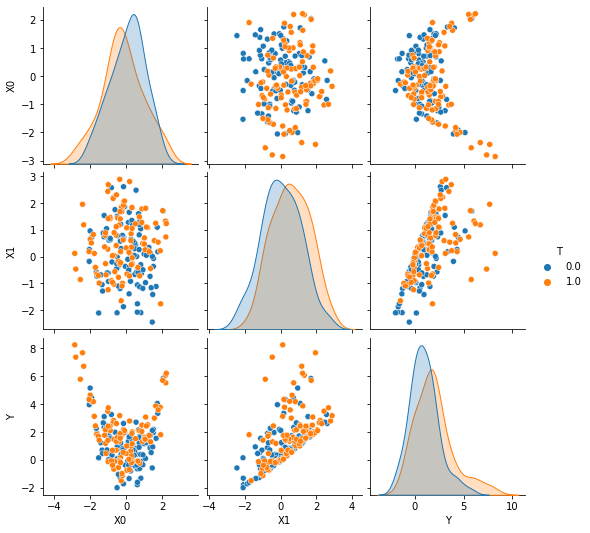

In [ ]:
b = sns.pairplot(df, hue ="T")

In [ ]:
from datetime import datetime


In [ ]:
now = datetime.now()

In [ ]:
now.strftime("%m-%d %H:%M:%S")

'08-07 16:15:09'

In [ ]:
from src.utils import cme_cross_validate_weighted,kernel_mean_matching

In [ ]:
cme_cross_validate_weighted(data_train,data_val,X_ker,Y_ker,reg_param=1,T_val=0)

RuntimeError: The size of tensor a (42) must match the size of tensor b (48) at non-singleton dimension 1

In [ ]:
def cme_cross_validate_weighted(data_train,data_val,X_ker,Y_ker,reg_param,T_val=0):
        
        K = ker(X_ker)
        L = ker(Y_ker)

        X_train_data = data_train.X[data_train.T == T_val]
        Y_train_data = data_train.Y[data_train.T == T_val]

        W = get_W_matrix(X_ker(X_train_data).evaluate(),reg_param,"cme")

        X_val_data = data_val.X[data_val.T == T_val]
        Y_val_data = data_val.Y[data_val.T == T_val]

        return_weights = kernel_mean_matching(X_ker, X_val_data, data_val.X)
        return_weights_matrix = torch.diag(return_weights)

        val_stat = torch.trace(return_weights_matrix@(L(Y_val_data,Y_val_data) -2 * K(X_train_data,X_val_data).T @ (W @ (L(Y_train_data,Y_train_data))) + (K(X_train_data,X_val_data).T @ (W @ (L(Y_train_data,Y_train_data)@ (W @ (K(X_train_data,X_val_data))))))))
        return val_stat

In [ ]:
T_val = 0
reg_param = 1
X_train_data = data_train.X[data_train.T == T_val]
Y_train_data = data_train.Y[data_train.T == T_val]

W = get_W_matrix(X_ker(X_train_data).evaluate(),reg_param,"cme")

X_val_data = data_val.X[data_val.T == T_val]
Y_val_data = data_val.Y[data_val.T == T_val]

return_weights = kernel_mean_matching(X_ker, X_val_data, data_val.X).squeeze(0)
return_weights_matrix = torch.diag(return_weights)

val_stat = torch.trace(return_weights_matrix@(L(Y_val_data,Y_val_data) -2 * K(X_train_data,X_val_data).T @ (W @ (L(Y_train_data,Y_val_data))) + (K(X_train_data,X_val_data).T @ (W @ (L(Y_train_data,Y_train_data)@ (W @ (K(X_train_data,X_val_data))))))))

In [ ]:
(K(X_train_data,X_val_data).T @ (W @ (L(Y_train_data,Y_train_data)@ (W @ (K(X_train_data,X_val_data)))))).shape

torch.Size([42, 42])

In [ ]:
(K(X_train_data,X_val_data).T @ (W @ (L(Y_train_data,Y_val_data)))).shape

torch.Size([42, 42])

In [ ]:
torch.diag(return_weights.squeeze(0))

tensor([[ 6.5199e+01,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  5.9489e+02,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00, -3.1570e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        ...,
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  7.4104e+00,
          0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          6.4893e+01,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00, -1.8914e-01]], grad_fn=<DiagBackward0>)

In [ ]:
data_val.T.sum()

tensor(46.)

In [ ]:
result_dict = kernel_permutation_test(data_train,data_test,X_ker,Y_ker,weights_model,test_stat="DATE",n_bins=10,n_permutations=100,reg=1,KMM_weights=True)

RuntimeError: Q is not SPD.

In [ ]:
len(data_val.T)

100

In [ ]:
X_val_data = data_val.X[data_val.T == 0]

In [ ]:
kernel_mean_matching(X_ker,data_test.X1,data_test.X)

RuntimeError: Q is not SPD.

In [ ]:
data_train.X

tensor([[ 0.2245, -0.0372],
        [ 0.2849,  1.3831],
        [-2.4144, -1.4844],
        [-1.0680,  0.5263],
        [ 0.9512, -1.5847],
        [ 0.4823, -0.4790],
        [-0.5240, -0.6070],
        [ 1.1552, -1.4885],
        [ 1.7344, -0.4447],
        [ 0.4220,  0.1468],
        [ 1.1870,  0.6172],
        [ 1.7036, -1.1028],
        [-0.8989,  0.4781],
        [-0.9170,  0.6102],
        [-0.4991,  0.3793],
        [ 0.3417, -0.9079],
        [ 0.9360, -0.6211],
        [ 1.1611,  1.1436],
        [ 0.6017,  0.3321],
        [-0.4207, -1.0678],
        [ 2.7563, -0.4940],
        [-1.5078,  0.6656],
        [-0.9820, -1.6307],
        [-1.7870,  0.8285],
        [ 0.2601,  0.8393],
        [ 0.6833,  0.6449],
        [-0.2842, -0.1314],
        [ 1.7600, -0.2359],
        [ 1.1459,  0.5760],
        [ 0.5180, -0.8124],
        [ 0.3778, -1.2391],
        [ 0.4066,  0.0221],
        [-1.2392,  0.2994],
        [-0.5706,  0.1944],
        [ 0.3937, -2.0141],
        [-0.2365, -1

In [ ]:
K = ker(X_ker)
L = ker(Y_ker)
W0 = get_W_matrix(X_ker(data_train.X0).evaluate(),1,"cme")
W1 = get_W_matrix(X_ker(data_train.X1).evaluate(),1,"cme")

In [ ]:
L(data_val.Y0,data_val.Y0) -2 * K(data_train.X0,data_val.X0).T @ (W0 @ (L(data_train.Y0,data_val.Y0)))+ (K(data_train.X0,data_val.X0).T @ (W0 @ (L(data_train.Y0,data_train.Y0)@ (W0 @ (K(data_train.X0,data_val.X0))))))

tensor([[ 9.9650e-01,  9.2141e-01,  4.0444e-02,  ...,  1.4607e-03,
          4.4177e-03,  4.3555e-01],
        [ 9.2173e-01,  9.9683e-01,  1.1443e-02,  ...,  6.1118e-03,
         -3.8566e-04,  6.7134e-01],
        [ 3.8187e-02,  1.0576e-02,  9.9769e-01,  ..., -6.4834e-04,
          7.7048e-01, -2.7286e-03],
        ...,
        [-2.0275e-04,  5.5464e-03, -2.8002e-03,  ...,  9.9733e-01,
         -1.8889e-03,  8.1355e-02],
        [ 5.1566e-03,  1.2083e-03,  7.7167e-01,  ..., -2.3636e-05,
          9.9996e-01, -1.0561e-04],
        [ 4.3827e-01,  6.7275e-01,  2.3699e-04,  ...,  8.0030e-02,
         -3.4985e-04,  9.9782e-01]], grad_fn=<AddBackward0>)

In [ ]:
# Load config file
with open("config/wrapped_simulaton_cfg.yaml", "r") as f:
    cfg = yaml.safe_load(f)

In [ ]:
cfg

{'moving_param': {'beta_scalar': True,
  'n_train_sample': False,
  'n_test_sample': False,
  'values': [0, 0.05]},
 'experiment': {'n_iter': 2,
  'test_stat': ['DATE', 'DETT'],
  'comparison_model': ['TMLE', 'DML'],
  'ker_regress': ['cme', 'zero'],
  'weights_model': 'MLP',
  'X_ker': 'RBF',
  'Y_ker': 'RBF',
  'significance_level': 0.05,
  'n_bins': 20,
  'cme_reg': 0.01,
  'permute_weights': True,
  'KMM_weights': True},
 'data': {'generator': 'linear_data_simulation',
  'n_train_sample': 50,
  'n_test_sample': 50,
  'arguments': {'alpha_vec': [0.1, 0.2, 0.3, 0.4, 0.5],
   'beta_vec': [0.1, 0.2, 0.3, 0.4, 0.5],
   'beta_scalar': 0.2,
   'effect_var': 'Unif',
   'noise_Y': 0.2}}}

In [ ]:
import doubleml as dml

In [ ]:
df = data_train.pd_df()

In [ ]:
X_cols = [col for col in df.columns if col.startswith("X")]

In [ ]:
dml_data = dml.DoubleMLData(df,y_col="Y",d_cols="T",x_cols = X_cols)

In [ ]:
from sklearn.base import clone

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LassoCV

learner = RandomForestRegressor(n_estimators = 500, max_features = 'sqrt', max_depth= 5)

ml_l_bonus = clone(learner)

ml_m_bonus = clone(learner)

learner = LassoCV()

ml_l_sim = clone(learner)

ml_m_sim = clone(learner)
obj_dml_plr_bonus = dml.DoubleMLPLR(dml_data, ml_l_bonus, ml_m_bonus)

In [ ]:
obj_dml_plr_bonus.fit()

KeyboardInterrupt: 

In [ ]:
obj_dml_plr_bonus.pval

array([0.98513103])

In [ ]:
from src.comparison_models import tmle_test

In [ ]:
tmle_test(data_test)

0.36474594203594113

In [ ]:
import os
import yaml
import seaborn as sns

In [ ]:
path_to_dir = "/Users/jakefawkes/Python/DR_distributional_test/sandbox/08-08 09:57:19"
os.chdir(path_to_dir)

In [ ]:
os.getcwd()

'/Users/jakefawkes/Python/DR_distributional_test/sandbox/08-08 09:57:19'

In [ ]:
with open("scores.metrics", "r") as f:
    results_dict = yaml.safe_load(f)
with open("cfg.yaml", "r") as f:
    cfg = yaml.safe_load(f)

In [ ]:
results_dict["result"] = [int(p_val <0.05) for p_val in results_dict["p_val"]]

In [ ]:
results_df = pd.DataFrame(results_dict)

In [ ]:
results_df

,beta_scalar,p_val,result,test_stat
0,0,0.645000,0,DATEcme
1,0,0.860000,0,DATEzero
2,0,0.415000,0,DETTcme
3,0,0.390000,0,DETTzero
4,0,0.280816,0,TMLE
5,0,0.636334,0,DML
6,0,0.415000,0,DATEcme
7,0,0.520000,0,DATEzero
8,0,0.340000,0,DETTcme
9,0,0.355000,0,DETTzero


In [ ]:
if cfg["moving_param"]["beta_scalar"]:
    moving_param = "beta_scalar"
if cfg["moving_param"]["n_train_sample"]:
    moving_param = "n_sample"

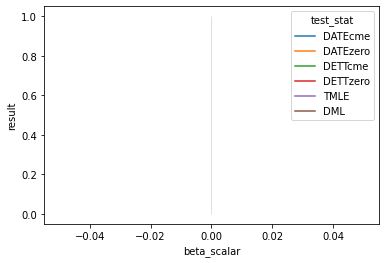

In [ ]:
plot = sns.lineplot(data = results_df,x=moving_param,y="result",hue = "test_stat")

In [ ]:
fig = plot.get_figure()

In [ ]:
fig.savefig("results_plot")

In [82]:
def load_IDHP():
    data = pd.read_csv("https://raw.githubusercontent.com/AMLab-Amsterdam/CEVAE/master/datasets/IHDP/csv/ihdp_npci_1.csv", header = None)
    col =  ["treatment", "y_factual", "y_cfactual", "mu0", "mu1" ,]
    for i in range(1,26):
        col.append("x"+str(i))
    data.columns = col
    data = data.astype({"treatment":'float'}, copy=False)
    data
    X = torch.tensor(data[["x"+str(i) for  i in range(1,26)]].values)
    Y = torch.tensor(data["y_factual"])
    T = torch.tensor(data["treatment"])
    Y_cf = torch.tensor(data["y_cfactual"])
    return X,Y,T,Y_cf


        

In [154]:
null_hypothesis = True

In [155]:
def IDHP_data_object(null_hypothesis = False):
    X,Y,T,Y_cf = load_IDHP()
    if null_hypothesis:
        rand_mat = torch.rand(a.shape)
        k_th_quant = torch.topk(rand_mat, 1, largest = False)[0][:,-1:]
        mask = rand_mat <= k_th_quant
        Y = (torch.concat([Y.unsqueeze(1),Y_cf.unsqueeze(1)],axis=1))[mask]
    perm = torch.randperm(len(Y))
    prop = torch.randn(len(Y)) > 0 
    X_train, Y_train, T_train = X[perm][prop], Y[perm][prop], T[perm][prop]
    X_test, Y_test, T_test = X[perm][~prop], Y[perm][~prop], T[perm][~prop]
    data_train = Data_object(X_train, Y_train, T_train)
    data_test = Data_object(X_test, Y_test, T_test)
    data_full =data_test.join(data_train)
    return data_train, data_test, data_full

In [141]:
IDHP_data_object(null_hypothesis = True)

In [151]:
sum(mask[:,0])

tensor(388)

In [81]:

    X,Y,T,Y_cf = load_IDHP()
    if random_permutation:

SyntaxError: unexpected EOF while parsing (3897669998.py, line 3)

In [128]:
idx

tensor([ 9,  5, 14,  3,  1,  7,  7,  0])